<a href="https://colab.research.google.com/github/parulnith/Data-Science-Articles/blob/main/Explaining%20models%20built%20in%20H2O%E2%80%8A-Part%C2%A01/Explaining_models_built_in_H2O%E2%80%8A_%E2%80%8APart%C2%A01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining models built in H2O - Part 1
### Evaluating single models based on global and local explanations

Machine Learning explainability refers to understanding and interpreting the decisions and predictions made by a machine learning model. Explainability is crucial for ensuring the trustworthiness and transparency of machine learning models, particularly in high-stakes situations where the consequences of incorrect predictions can be significant.

Today, several techniques are available to improve the explainability of a machine learning model, such as visualising the model’s decision-making process and using techniques like feature importance analysis to understand the factors that most influence the model’s predictions. Some algorithms, like generalized linear models, decision trees, and generalized additive models, are designed to be inherently interpretable. For interpretable models, the explanations native to the model frequently prove to be the most useful.  Other algorithms, like gradient-boosting trees and neural networks, are infamous for their black-box nature. In such cases, post- hoc techniques provide a way to explain the model’s predictions after it has been trained.

[H2O-3](https://h2o.ai/platform/ai-cloud/make/h2o/) is a fully open-source, distributed, in-memory machine-learning platform with linear scalability. Apart from supporting the most widely used statistical and machine learning algorithms, it also has a dedicated toolkit for [Model Explainability](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html), making it easy to visualise and assess the predictions from the models. 

This notebook explains how to train a baseline gradient boosting machine (GBM) model in H2O-3 and then derive global and local explanations for the predictions. At the end of the article, you should understand how to generate, explain and interpret the results of machine learning models trained using H2O-3.


### Step 1: Setting up the environment

We’ll start by installing the latest version of H2O-3. 

In [ ]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.5 MB 53 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.3-py2.py3-none-any.whl size=177541401 sha256=15ecb284d61aca2722a93db8eab3a7f63747d2708cc6c5e8bd5053f9ebbf8aba
  Stored in directory: /root/.cache/pip/wheels/16/f8/f4/69e1ff6a0d1cb61bdbc0d9888ee8437a1acf1eb1c6ffb8be20
Successfully built h2o


H2O-3 can also be downloaded and installed from its [official website](https://h2o.ai/resources/download/). The next step is to set up the environment by importing the necessary libraries and initialising H2O by starting the H2O-3 server.

In [ ]:
import numpy as np   

# Visualization Libraries
import matplotlib.pyplot as plt

## H2O-3 algorithms
import h2o
from h2o.estimators import H2OGradientBoostingEstimator

# global random seed for better reproducibility
SEED = 12345

h2o.init(max_mem_size='4G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators

# Ignoring the warnings
import warnings  
warnings.filterwarnings(action = "ignore")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpu5ulut4t
  JVM stdout: /tmp/tmpu5ulut4t/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpu5ulut4t/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_0761f2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Step 2: Loading the dataset

We’ll train a baseline GBM model in H2O-3 using a preprocessed version of the [lending club](https://www.lendingclub.com/investing/peer-to-peer) “bad loans” dataset. The Lending Club dataset is a collection of financial data related to loans issued by the Lending Club, a peer-to-peer lending company. This dataset is also available on Kaggle. We’ll train a model to predict whether or not a borrower will pay off the loan. H2O works with R, Python, and Scala on Hadoop/Yarn, Spark or your laptop; however, in this article, we’ll be working with Python.

H2O-3 supports various data formats, including CSV, TSV, and Excel files. We’ll use the `h2o.import_file()` method to load the data into H2O-3 by specifying the file’s path, which in our case, is in an S3 bucket. To ensure the dataset is imported correctly, we’ll use the .head() function to display the first ten rows of your dataset

In [ ]:
input_csv = "https://s3.amazonaws.com/data.h2o.ai/Machine-Learning-at-Scale/lending_club/loans.csv"

loans = h2o.import_file(input_csv)
loans.head()

loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,credit_length
5000,36 months,10.65,10,RENT,24000,verified,1.3227e+12,credit_card,AZ,27.65,0,83.7,9,0,26
2500,60 months,15.27,0,RENT,30000,verified,1.3227e+12,car,GA,1,0,9.4,4,1,12
2400,36 months,15.96,10,RENT,12252,not verified,1.3227e+12,small_business,IL,8.72,0,98.5,10,0,10
10000,36 months,13.49,10,RENT,49200,verified,1.3227e+12,other,CA,20,0,21,37,0,15
5000,36 months,7.9,3,RENT,36000,verified,1.3227e+12,wedding,AZ,11.2,0,28.3,12,0,7
3000,36 months,18.64,9,RENT,48000,verified,1.3227e+12,car,CA,5.35,0,87.5,4,0,4
5600,60 months,21.28,4,OWN,40000,verified,1.3227e+12,small_business,CA,5.55,0,32.6,13,1,7
5375,60 months,12.69,0,RENT,15000,verified,1.3227e+12,other,TX,18.08,0,36.5,3,1,7
6500,60 months,14.65,5,OWN,72000,not verified,1.3227e+12,debt_consolidation,AZ,16.12,0,20.6,23,0,13
12000,36 months,12.69,10,OWN,75000,verified,1.3227e+12,debt_consolidation,CA,10.78,0,67.1,34,0,22


As indicated in the table above, the dataset consists of various predictor variables like loan amount, term, and interest rate, plus one target variable called bad_loan. The target variable is  1 if the loan was bad and 0 otherwise.

## Step 3: Train a baseline GBM(Gradient Boosting Machine) model in H2O-3
Since we’ll train a binary classification model, it is important to ensure that the target column is encoded as a factor. 



In [ ]:
loans["bad_loan"] = loans["bad_loan"].asfactor()


In [ ]:
loans["bad_loan"].table()

bad_loan,Count
0,32776
1,6204


In [ ]:
SEED = 12345

Next, we’ll split the data into training, validation and test sets. It is crucial to split the data into training and test sets to evaluate the performance of the GBM model. We’ll use the h2o.split_frame() method to split the data into three sets, with a specified ratio of data for training, validation and testing.

In [ ]:
train, valid, test = loans.split_frame([0.7, 0.15], seed=SEED)

In [ ]:
print("train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows))

train:27304 valid:5753 test:5923


Specifying the inputs (predictors) and outputs (response) columns. 

In [ ]:
target = "bad_loan"

ignore = ["bad_loan", "issue_d"] 

predictors = list(set(train.names) - set(ignore))

Now that we have our train, valid, and test sets and our target and predictor variables defined, we can start training the model. It can be done by calling the `model.train()` method and passing the training data.

H2O will give you a complete summary of your model. You will see your model’s metrics on the training and validation sets. We can see details about the model, including our model’s parameters and metrics, the confusion matrix, thresholds that maximize metrics such as F1, a Gains/Lift table, and the scoring history.



In [ ]:
gbm = H2OGradientBoostingEstimator(seed = 42)

gbm.train(
    x = predictors,
    y = target,
    training_frame = train,
    validation_frame = valid,
    model_id = 'baseline_gbm')

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: baseline_gbm


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          25799                  5            5            5             22            32            29.42

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10830780677601105
RMSE: 0.3291015143933723
LogLoss: 0.35566237744528156
Mean Per-Class Error: 0.29472469178177096
AUC: 0.8048299193386576
AUCPR: 0.5125496434578467
Gini: 0.6096598386773151

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2292829962211712
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      19868  3051  0.1331   (3051.0/22919.0)
1      2001   2384  0.4563   (2001.0/4385.0)
Total  21869  5435  0.185    (5052.0/27304.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.229283     0.48554   200
max f2                       0.135843     0.597147  280
max f0point5                 0.37105      0.515097  123
max accuracy                 0.405799     0.861595  105
max precision                0.951465     1         0
max recall                   0.0307132    1         388
max specificity              0.951465     1         0
max absolute_mcc             0.236696     0.379435  195
max min_per_class_accuracy   0.166936     0.721779  250
max mean_per_class_accuracy  0.175928     0.723713  242
max tns                      0.951465     22919     0
max fns                      0.951465     4384      0
max fps                      0.0160885    22919     399
max tps                      0.0307132    4385      388
max tnr                      0.951465     1         0
max fnr                      0.951465     0.999772  0
max fpr                      0.0160885    1         399
max tpr                      0.0307132    1         388

Gains/Lift Table: Avg response rate: 16.06 %, avg score: 16.08 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------  --------------------
1        0.0100352                   0.60683            5.86308   5.86308            0.941606         0.691203   0.941606                    0.691203            0.0588369       0.0588369                  486.308    486.308            0.0581388
2        0.0200337                   0.5175             4.99503   5.42985            0.802198         0.557094   0.872029                    0.624271            0.049943        0.10878                    399.503    442.985            0.105726
3        0.0300322                   0.471785           4.3564    5.07247            0.699634         0.492089   0.814634                    0.580264            0.0435576       0.152338                   335.64     407.247            0.145705
4        0.0400308                   0.438537           3.87742   4.77398            0.622711         0.454269   0.766697                    0.548794            0.0387685       0.191106                   287.742    377.398            0.17998
5        0.0500293                   0.412492           3.19317   4.45805            0.512821         0.424804   0.715959                    0.524014 

In [ ]:

perf = gbm.model_performance(test)
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.12418957875097435
RMSE: 0.3524054181634759
LogLoss: 0.40301104043357816
Mean Per-Class Error: 0.3636327543722528
AUC: 0.6981174429569464
AUCPR: 0.2997959293693403
Gini: 0.3962348859138929

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18770646939887628
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      3743  1246  0.2497   (1246.0/4989.0)
1      446   488   0.4775   (446.0/934.0)
Total  4189  1734  0.2857   (1692.0/5923.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.187706     0.365817  219
max f2                       0.0882582    0.528209  326
max f0point5                 0.248284     0.343423  172
max accuracy                 0.596128     0.843323  29
max precision                0.889525     1         0
max recall                   0.0217522    1         395
max specificity              0.889525     1         0
max absolute_mcc             0.248284     0.227184  172
max min_per_class_accuracy   0.155005     0.633193  254
max mean_per_class_accuracy  0.173558     0.638377  234
max tns                      0.889525     4989      0
max fns                      0.889525     933       0
max fps                      0.0134696    4989      399
max tps                      0.0217522    934       395
max tnr                      0.889525     1         0
max fnr                      0.889525     0.998929  0
max fpr                      0.0134696    1         399
max tpr                      0.0217522    1         395

Gains/Lift Table: Avg response rate: 15.77 %, avg score: 16.21 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01013                     0.590282           3.38216   3.38216            0.533333         0.664283   0.533333                    0.664283            0.0342612       0.0342612                  238.216   238.216            0.0286489
2        0.0200912                   0.500928           2.14968   2.77109            0.338983         0.535563   0.436975                    0.600464            0.0214133       0.0556745                  114.968   177.109            0.042245
3        0.0300523                   0.459679           2.47213   2.672              0.389831         0.479425   0.421348                    0.560344            0.0246253       0.0802998                  147.213   167.2              0.0596544
4        0.0400135                   0.429434           2.57961   2.649              0.40678          0.443695   0.417722                    0.531305            0.0256959       0.105996                   157.961   164.9              0.0783349
5        0.0501435                   0.405156           1.58539   2.43413            0.25             0.416683   0.383838                    0.508149            0.01606         0.122056                   58.5385   143.413            0.085375
6        0.100118                    0.324465           2.20669   2.3206             0.347973         0.359864   0.365936                    0.434131            0.110278        0.232334                   120.669   132.06             0.156968
7        0.150093                    0.270207           1.84247   2.1614             0.290541         0.297804   0.340832                    0.38874             0.0920771       0.324411                   84.2475   116.14             0.206953
8        0.200068        

After the GBM model has been trained, you can evaluate its performance by calling the `model.model_performance()` method and passing the held-out test data. This will return an object that contains various metrics, such as accuracy, AUC, and F1 score, that we can use to evaluate the model’s performance.

In [ ]:
print(np.round(gbm.model_performance(train).auc(),3),
      np.round(gbm.model_performance(valid).auc(),3),
      np.round(gbm.model_performance(test).auc(),3))

0.805 0.724 0.698


These findings demonstrate that our baseline model overfits the training data. While the focus of this article is to showcase the various explainability features of H2O-3, you are nevertheless encouraged to improve the test and validation AUCs. See the [tuning a GBM](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm-faq/tuning_a_gbm.html?_ga=2.120977614.777813095.1680173633-674755624.1667559253) for more information on the configurable parameters within the GBM module.

# Explanations for single models

Once the model has been trained and evaluated on the held-out dataset and shows good performance, the next step in the ML pipeline is to understand how the predictions are made and which features the model relies on most to make those predictions. The H2O-3’s explainability interface can provide both global as well as local explanations for single and multiple models. 

*This notebook will only look at the explanations generated for single models. The multiple model scenario will be addressed in the second part of this article.*


## Global Explanations for single models

Global explanations refer to the ability of a model to provide explanations for its predictions at a global level rather than just for individual inputs. This means that the explanations provided by the model apply to the model as a whole rather than just to specific input examples. Global explanations can help understand the overall behaviour of a model and can help users gain confidence in the model’s predictions.

Global explanations in H2O-3 are generated as follows:

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## baseline_gbm

,0,1,Error,Rate
0,3743.0,1246.0,0.2497,(1246.0/4989.0)
1,446.0,488.0,0.4775,(446.0/934.0)
Total,4189.0,1734.0,0.2857,(1692.0/5923.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

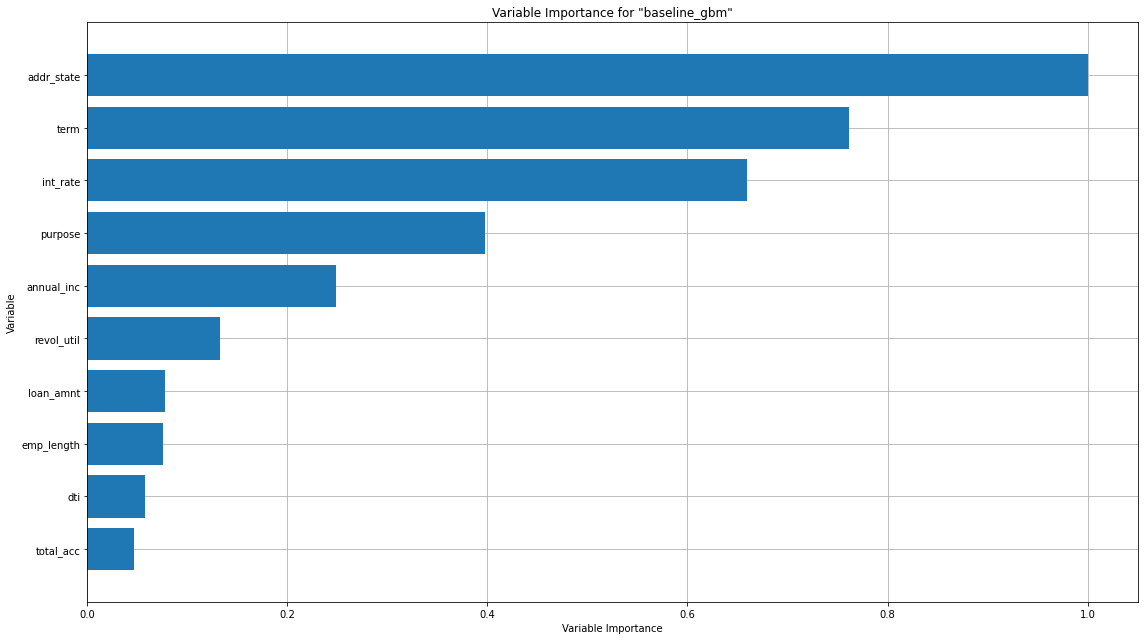

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

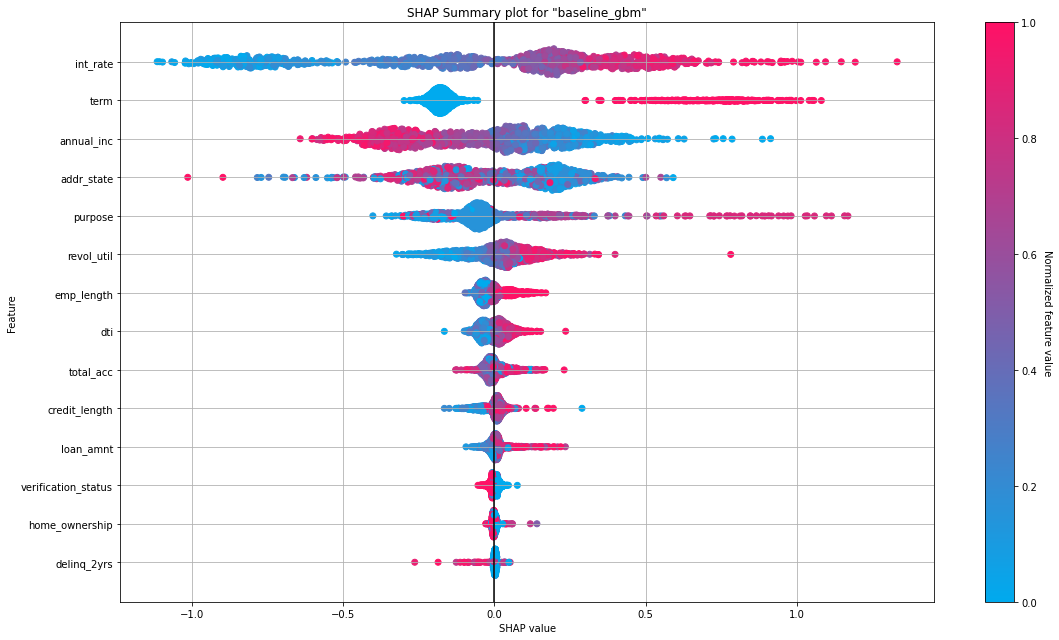

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

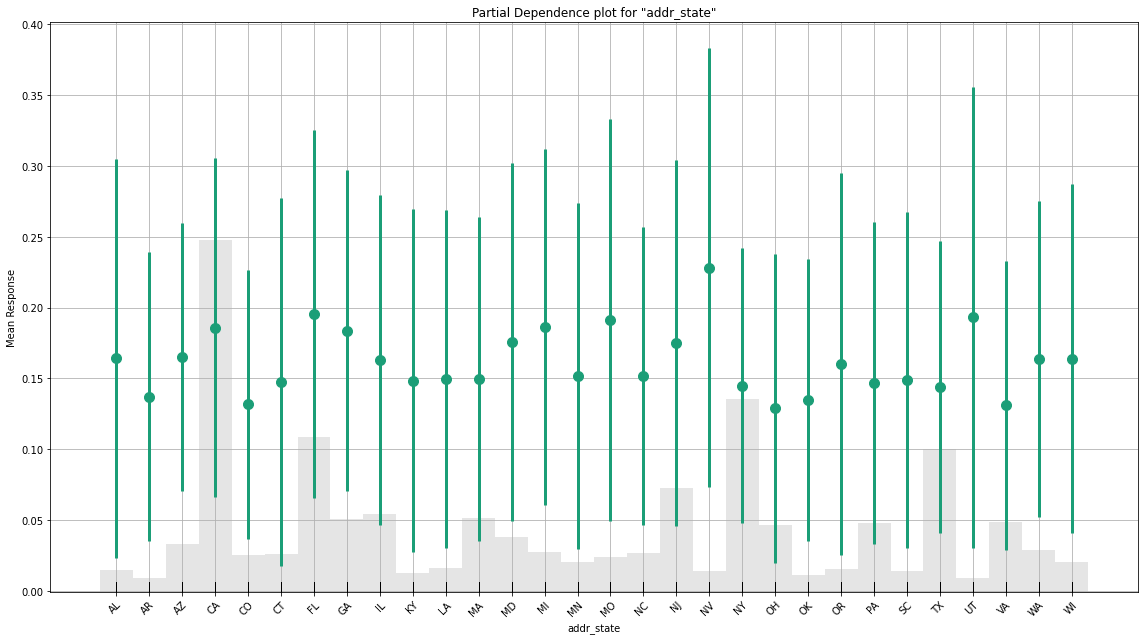

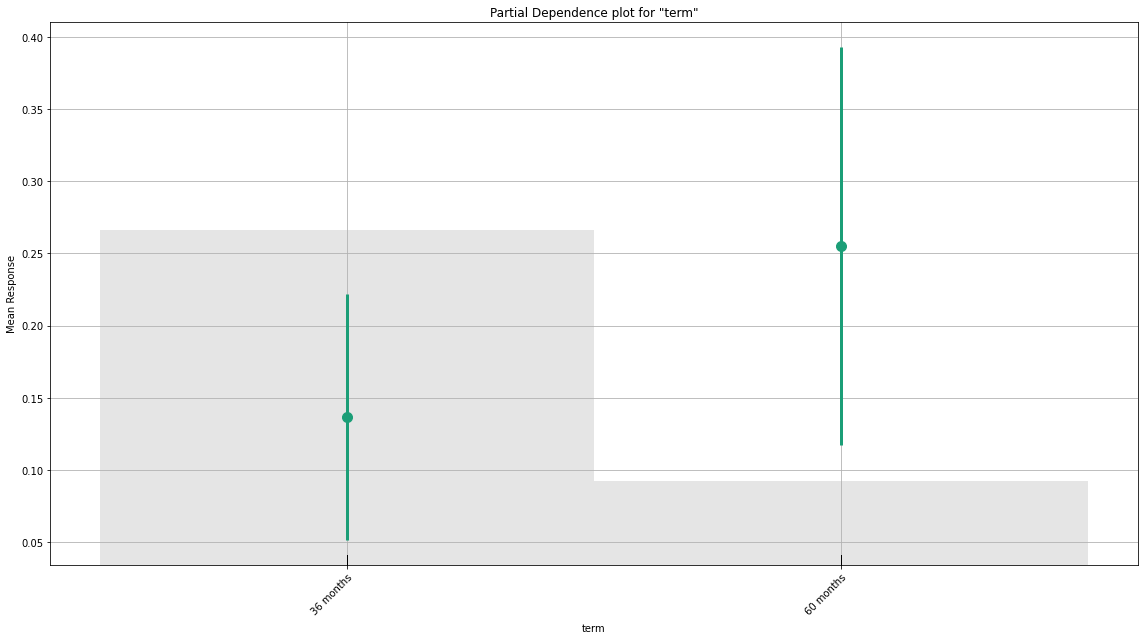

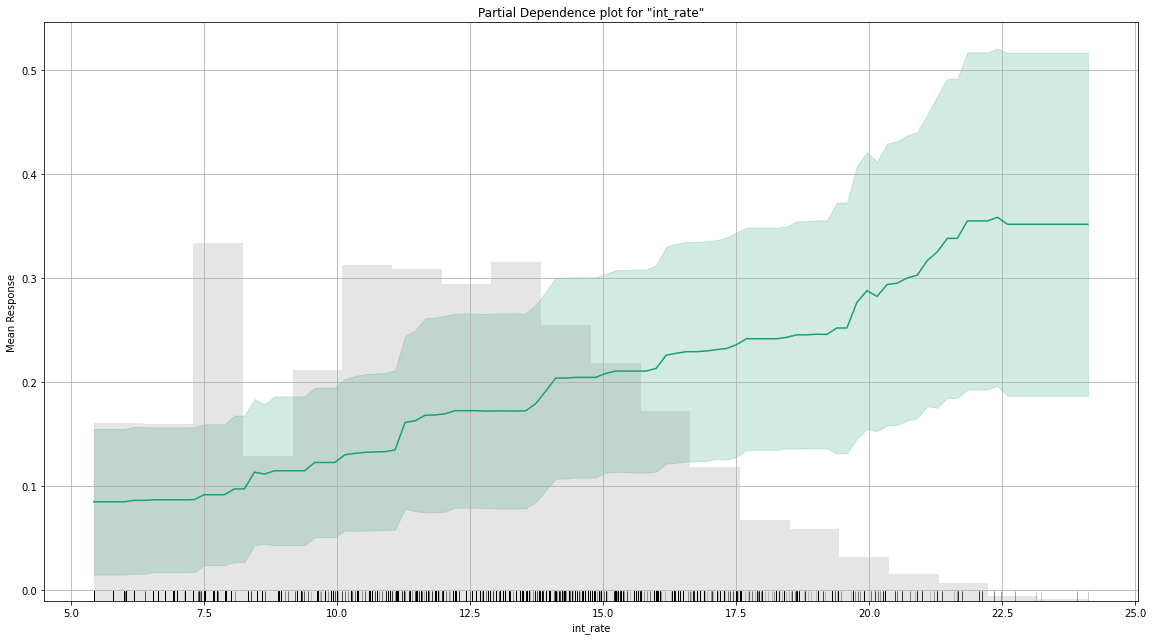

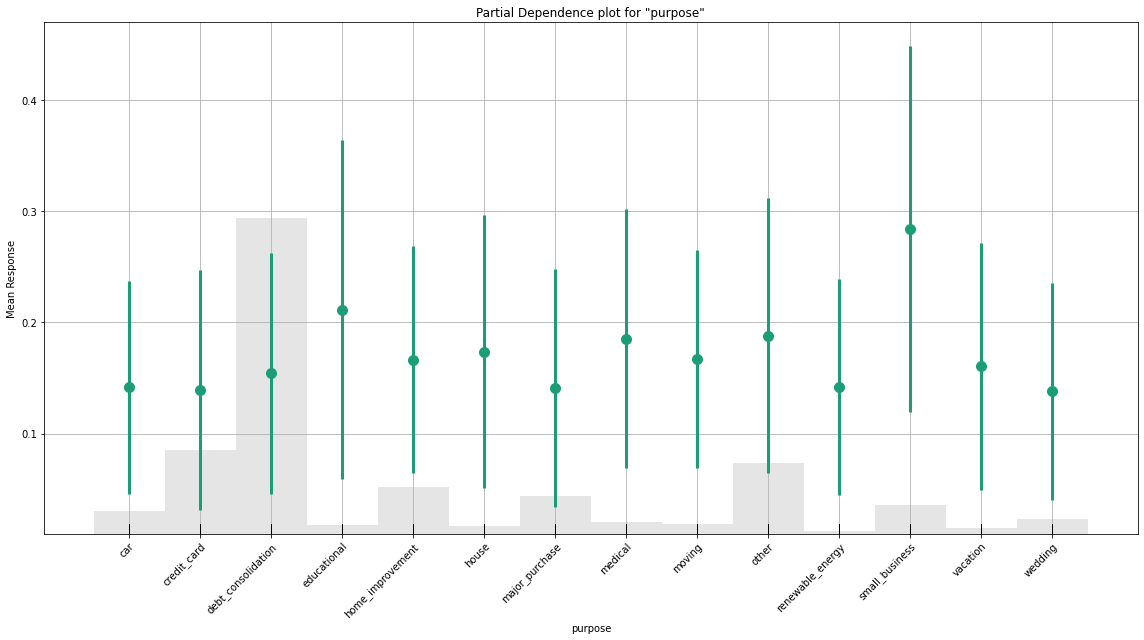

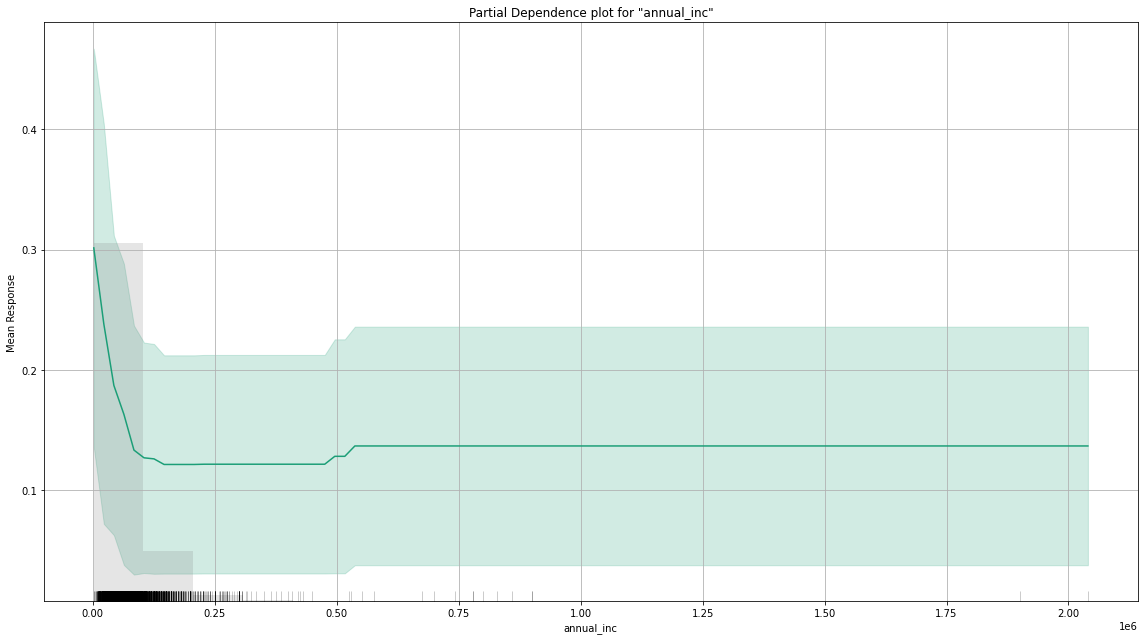

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## baseline_gbm

,0,1,Error,Rate
0,3743.0,1246.0,0.2497,(1246.0/4989.0)
1,446.0,488.0,0.4775,(446.0/934.0)
Total,4189.0,1734.0,0.2857,(1692.0/5923.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [ ]:
gbm.explain(test)

## Individual plotting functions

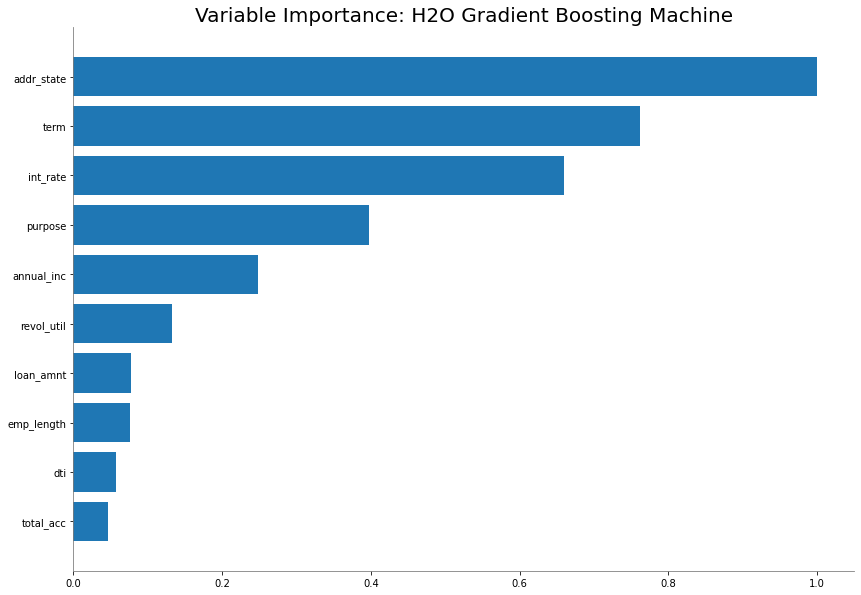

<Figure size 432x288 with 0 Axes>

In [ ]:
gbm.varimp_plot()

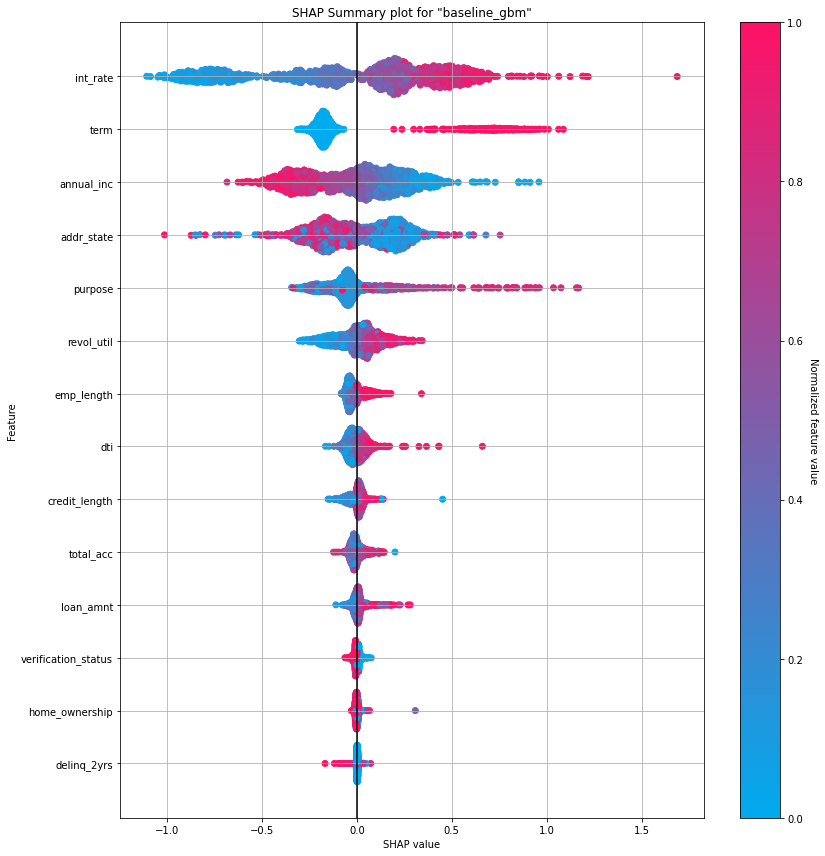

In [ ]:
gbm.shap_summary_plot(test)

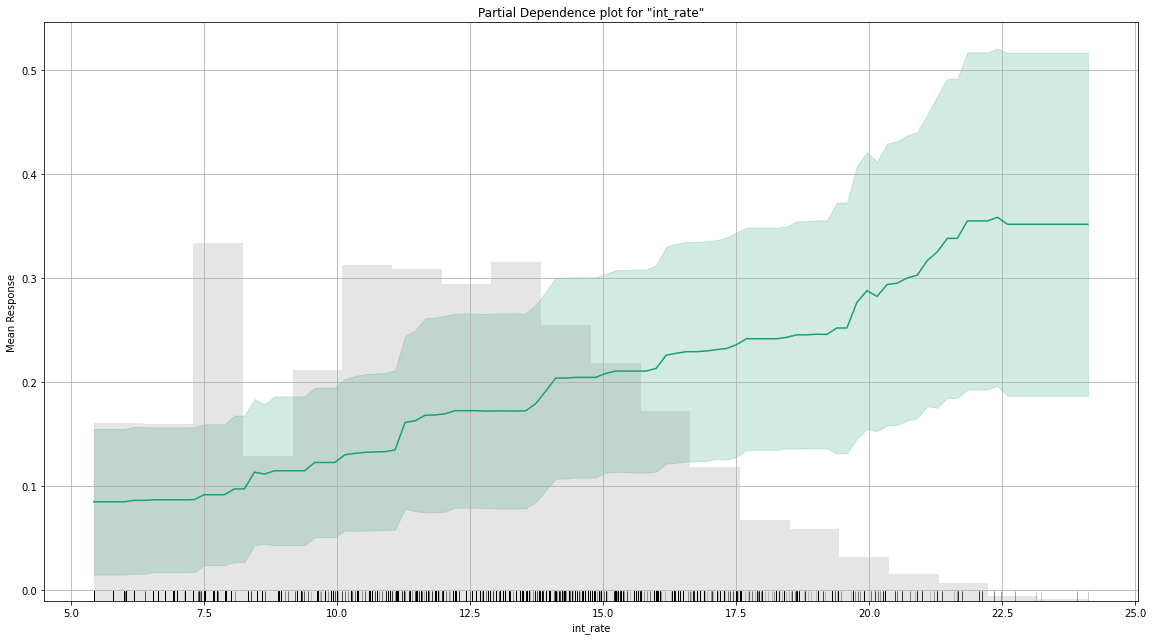

In [ ]:
gbm.pd_plot(test, column = 'int_rate')

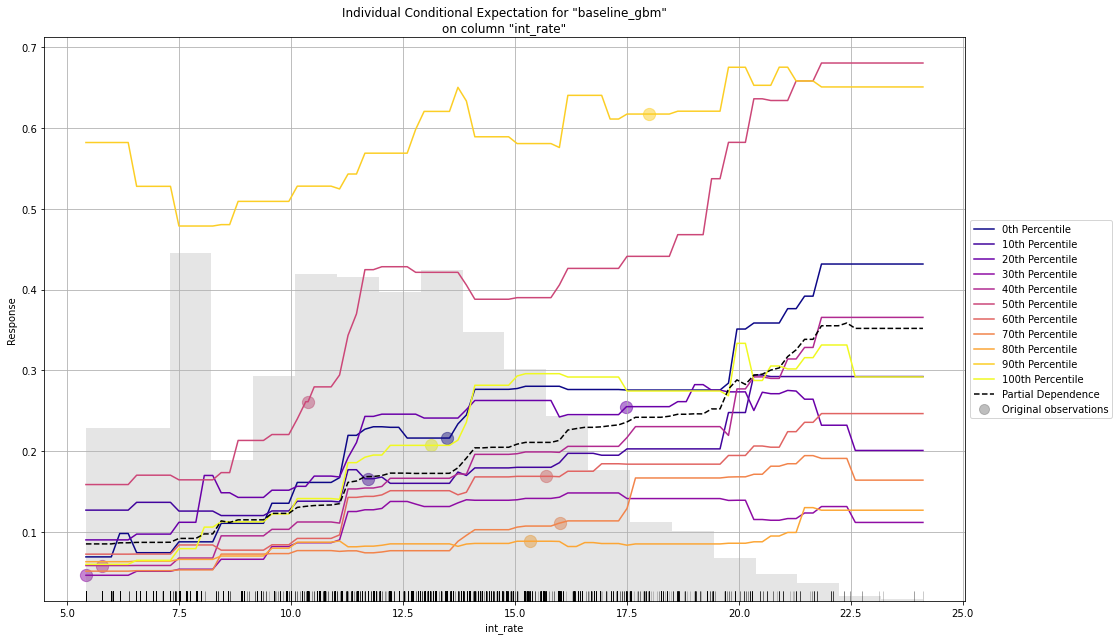

In [ ]:
gbm.ice_plot(test, column = 'int_rate')

## Local Explanations for single models

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

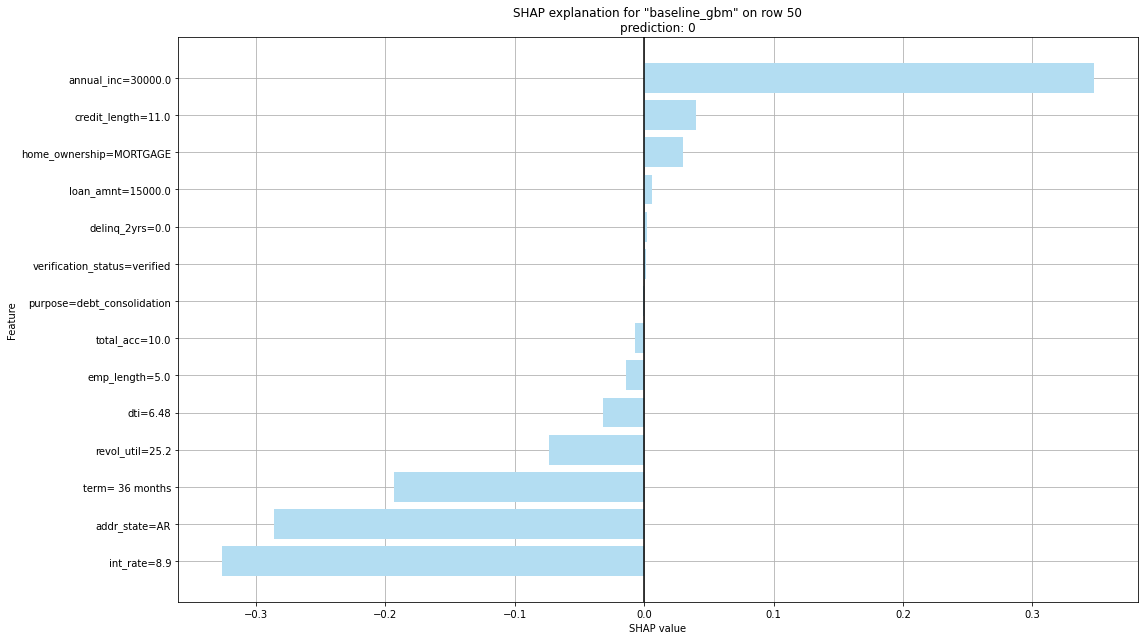

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

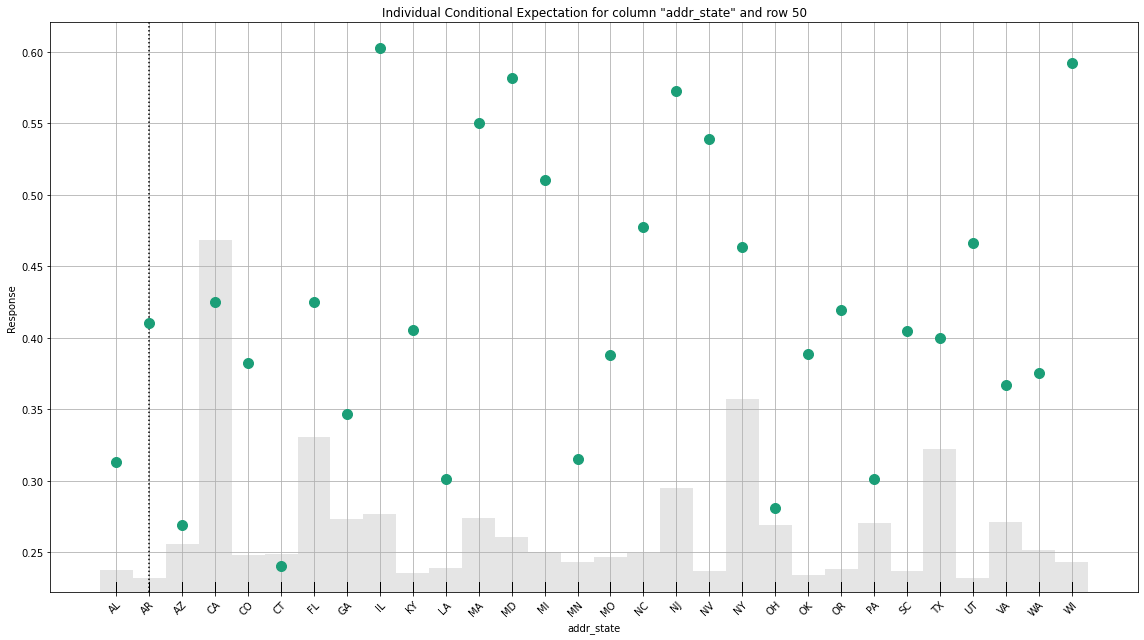

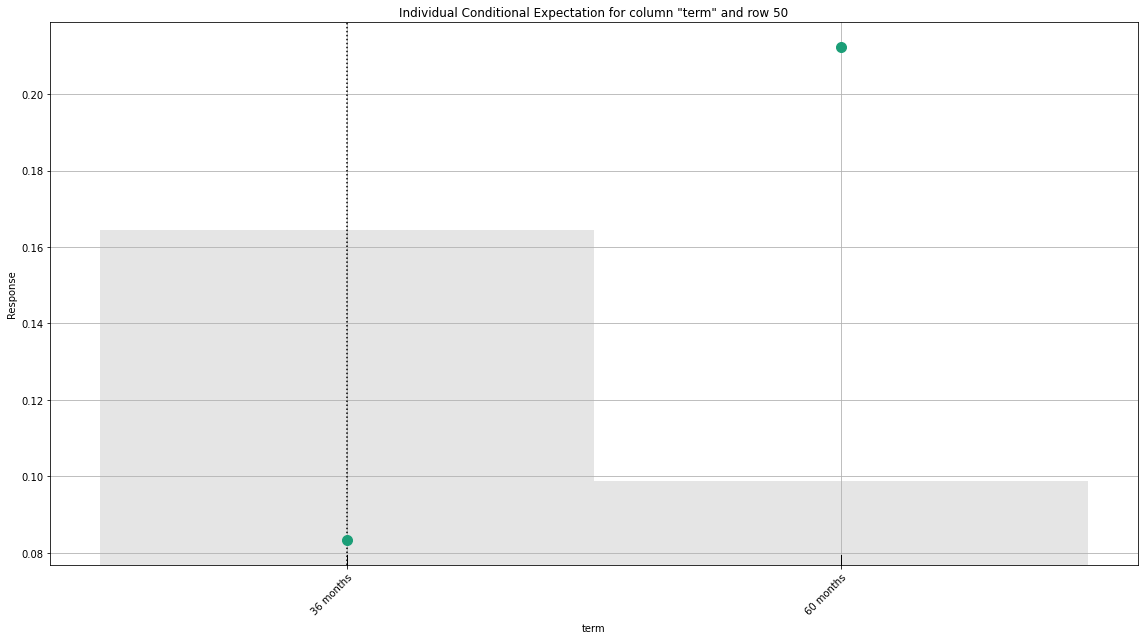

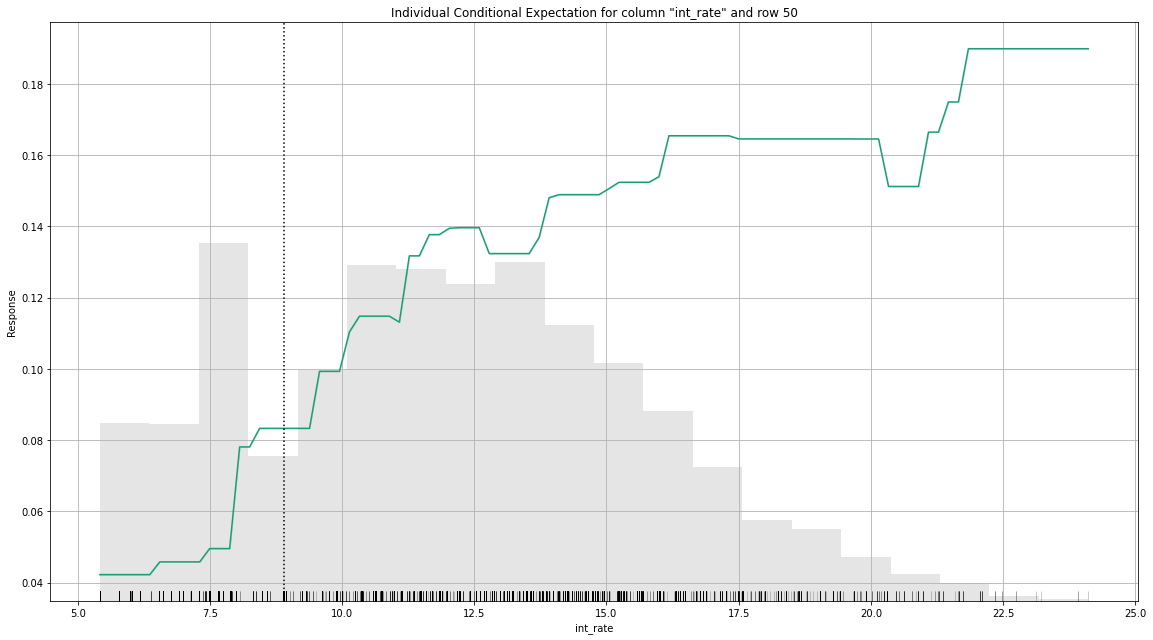

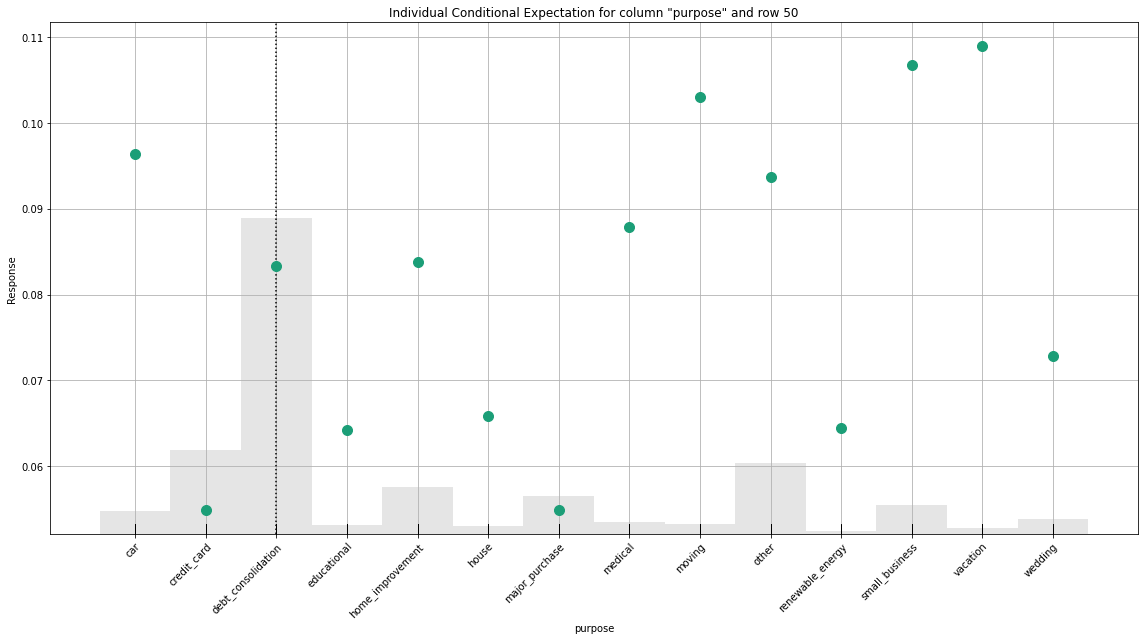

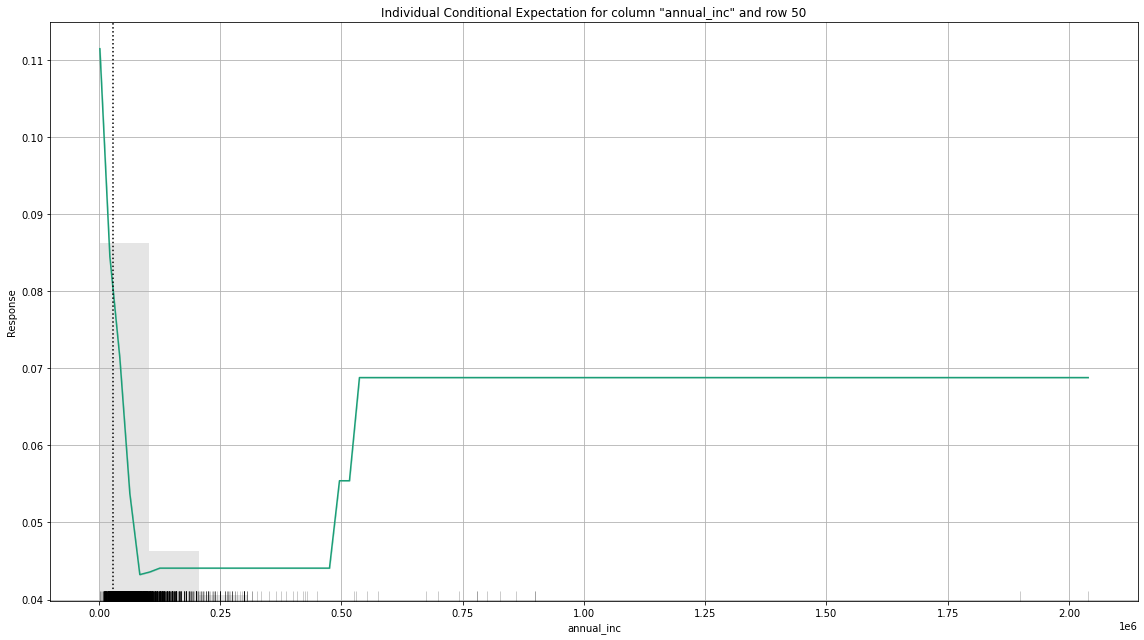

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

In [ ]:
gbm.explain_row(test, row_index=50)

In [ ]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_9dd9 closed.
